In [1]:
import numpy as np, random, math
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import collections

&bull; Write a code for structuring the data so that the library routine can find the maximal-margin solution.<br>
&bull; The location of the decesion boundary is given by the weights (w) and the bias (b).<br>
&bull; Find the values for w and b which maximizes the margin (distance to any datapoint).
<img src="equations/optimize.png">

&bull; &uarr; C value will result in &darr; Slack, which will result in narrower margin

&bull; If you have noisy data -> use low C value to allow for more slack

# Variables:

In [2]:
C = 2
upper = False # upper boundary for bounds
threshold = 10**-5 # zero threshold
kernelType = 'pol' # type of kernel (lin,pol,RBF)
np.random.seed(100)
pointsN=40 # number of data points
SD = 0.2 #standard Deviation in the data
#kernel settings
pol = 1 #polynomial degree
sigma = 1 #smoothness of curve in RBF kernel

&bull; The objective equation (dual formulation)
<img src="equations/objective.png">

&bull; The optimization problem can be transformed into a different form, called the dual problem, which has some computational advantages.<br>
&bull; It makes it possible to use the kernel trick, which eleminates the need for evualuating the transformation function.

In [3]:
def objective (alpha):
    return 0.5*np.dot(alpha,np.dot(alpha,pre_compute)) - np.sum(alpha)

the Kernel equations:
<img src="equations/linearK.png">
<img src="equations/polynomialK.png">
<img src="equations/RBFK.png">

In [4]:
def kernel(a,b,pol,sigma):
    if kernelType == 'lin':
        return np.dot(a,b)
    
    elif kernelType == 'pol':
        return (np.dot(a,b) + 1)**pol
    
    elif kernelType == 'RBF':
        return math.exp(-np.linalg.norm(np.subtract(a,b),ord=2)/(2*sigma**2))
    
    elif kernelType == 'null':
        return 2
    else:
        raise Exception("Kernel not found")

Lagrange multiplier constraints:
<img src="equations/constraint.png">

In [5]:
def zerofun (alpha):
    
    return np.dot(alpha,targets)

bias (b) Value:
<img src="equations/b.png">

In [6]:
def b_calculator(non_zero):
    b = 0
    for current in non_zero:
        b += current['alpha']*current['t']*kernel(non_zero[2]['in'],current['in'],pol,sigma)
    return b - non_zero[2]['t']

indicator equation:
<img src="equations/indicator.png">

In [7]:
def indicator(non_zero,unkown,b):
    ind = 0
    for current in non_zero:
        ind += current['alpha']*current['t']*kernel(unkown,current['in'],pol,sigma)
    return ind - b

In [8]:
#classA = np.concatenate((np.random.randn(int(pointsN/2),2)*SD+[1.5,0.5],
                        #np.random.rand(int(pointsN/2),2)*SD+[-1.5,0.5]))
classB = np.random.randn(pointsN,2)*SD+[0.0,-0.5]

#classA = np.array([[1,3],[1,4],[1,5],[2,4],[2,6],[3,5],[3,6],[4,5],[5,6],[7,6]])
classB = np.array([[2,1],[3,2],[4,2],[5,2],[6,1],[7,2]])

classA = np.array([[-1.8,-1],
                  [-1.2,0.2],
                  [-1,-1],
                  [-0.2,-1.8],
                  [0.2,-1.5],
                  [1.8,-2.1],
                  [1.1,-0.8],
                  [1.1,0.2],
                  [0.8,1.2],
                  [-0.5,1.2]])

classB = np.array([[-0.8,0.2],
                   [-0.7,-0.8],
                   [-0.2,-0.8],
                   [-0.1,0.8],
                   [0.2,0.8],
                   [0.5,0.8],
                   [0,0.2],
                   [0.2,0.1],
                   [-0.8,0.8],
                   [-0.1,0.8]])
inputs = np.concatenate ((classA,classB))
targets = np.concatenate (
(np.ones(classA.shape[0]),
-np.ones(classB.shape[0])))

N = inputs.shape[0]

permute = list(range(N))
random.shuffle(permute)
inputs = inputs[permute, :]
targets = targets [permute]

In [9]:
pre_compute = np.zeros(shape=(N,N))
for i in range(N):
    for j in range(N):
        pre_compute[i][j]=targets[i]*targets[j]*kernel(inputs[i],inputs[j],pol,sigma)

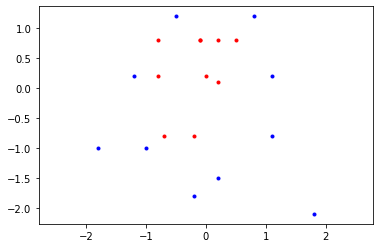

In [10]:
plt.plot([p[0] for p in classA],
        [p[1] for p in classA],
        'b.')
plt.plot([p[0] for p in classB],
        [p[1] for p in classB],
        'r.')

plt.axis('equal')
plt.savefig('svmplot.pdf')
plt.show()

In [11]:
initial_guess = np.zeros(N)


if upper:
    B= [(0,C) for b in range(N)]
else:
    B= [(0,None) for b in range(N)]

XC = {'type':'eq','fun':zerofun}

ret = minimize(objective,initial_guess,bounds=B,constraints=XC)

alpha = ret['x']
print ("zero_function result: ", np.dot(alpha,targets))
print(ret)

zero_function result:  -5.820766091346741e-11
     fun: -4471892.518431908
     jac: array([ 1574.    , -2749.6875,  2629.6875, -5876.75  , -2276.875 ,
        -215.75  ,  -883.375 ,   836.375 , -1522.5   ,   322.6875,
       -6245.9375,   136.25  ,   152.    ,  2845.75  , -2534.875 ,
        1369.    ,  3502.8125,  1586.875 ,  1689.375 ,   880.    ])
 message: 'Optimization terminated successfully'
    nfev: 2092
     nit: 70
    njev: 70
  status: 0
 success: True
       x: array([240164.1313039 , 187330.24982078, 347684.43764144, 153980.09481497,
       103154.0502078 , 143629.16246465, 202079.18651715, 177297.60304621,
       228642.32267528, 258192.69935566, 396048.16444895, 167060.35520451,
        12381.14684388, 213338.20121583, 167274.12364989, 440101.39686111,
        81727.91447788, 349200.88645715, 332543.82610142, 270232.52413156])


In [12]:
non_zero = []
for i, a in enumerate(alpha):
    #print(a)
    if a > threshold:
        non_zero.append({'alpha':a,'in':inputs[i],'t':targets[i]})
non_zero

[{'alpha': 240164.1313039046, 'in': array([0. , 0.2]), 't': -1.0},
 {'alpha': 187330.24982078242, 'in': array([0.5, 0.8]), 't': -1.0},
 {'alpha': 347684.4376414396, 'in': array([-1.2,  0.2]), 't': 1.0},
 {'alpha': 153980.09481496806, 'in': array([ 1.1, -0.8]), 't': 1.0},
 {'alpha': 103154.05020779774, 'in': array([ 0.2, -1.5]), 't': 1.0},
 {'alpha': 143629.1624646518, 'in': array([-0.8,  0.8]), 't': -1.0},
 {'alpha': 202079.18651714947, 'in': array([-1., -1.]), 't': 1.0},
 {'alpha': 177297.6030462149, 'in': array([0.2, 0.8]), 't': -1.0},
 {'alpha': 228642.3226752827, 'in': array([-1.8, -1. ]), 't': 1.0},
 {'alpha': 258192.69935565916, 'in': array([0.2, 0.1]), 't': -1.0},
 {'alpha': 396048.1644489522, 'in': array([0.8, 1.2]), 't': 1.0},
 {'alpha': 167060.355204514, 'in': array([-0.1,  0.8]), 't': -1.0},
 {'alpha': 12381.146843878718, 'in': array([ 1.8, -2.1]), 't': 1.0},
 {'alpha': 213338.2012158292, 'in': array([-0.8,  0.2]), 't': -1.0},
 {'alpha': 167274.12364988547, 'in': array([-0.1

In [13]:
b = b_calculator(non_zero)

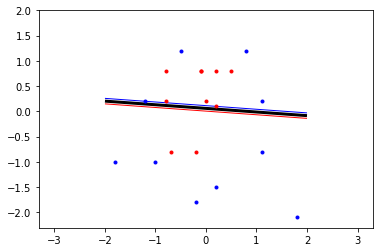

In [14]:
x_limits = 2
y_limits = 2
xgrid = np.linspace(-x_limits,x_limits)
ygrid = np.linspace(-y_limits,y_limits)

grid = np.array([[indicator(non_zero,[x,y],b)
                 for x in xgrid]
                for y in ygrid])
if ret['success']==True:
    plt.plot([p[0] for p in classA],
            [p[1] for p in classA],
            'b.')
    plt.plot([p[0] for p in classB],
            [p[1] for p in classB],
            'r.')

    plt.contour(xgrid,ygrid,grid,
               (-1.0,0.0,1.0),
               colors=('red','black','blue'),
               linewidths=(1,3,1))


    plt.axis('equal')
    plt.savefig('svmplot.pdf')
    plt.show()
else:
    print('Minimization failed succesfully')